In [1]:
from env import MazeEnv
from dqn_net_gym import CNNCom
from equivariant_dqn_net import EquivariantCNNCom
from memory import ReplayMemory
from utils.schedules import LinearSchedule

import copy
import tqdm
import torch
import numpy as np
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
from scipy.signal import convolve


In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

class CartPole():
    def __init__(self):
        self.env = gym.make("CartPole-v0", render_mode="rgb_array")
        self.action_space = [0, 1]

    def reset(self):
        state, _ = self.env.reset()
        return state, self.render()
        
    def render(self):
        gray_arr = rgb2gray(self.env.render())
        gray_padded_arr = np.concatenate([gray_arr, np.ones((200, 600))*gray_arr[0, 0]])
        return gray_padded_arr[::4,::4]

    def step(self, action):
        next_state, reward, done, truncated, _ = self.env.step(action)
        return np.round(next_state, 1), self.render(), reward, done or truncated

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

class Pendulum():
    def __init__(self):
        self.env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)
        self.action_space = list(range(25))
        self.actions = {key: value for key, value in zip(self.action_space, np.linspace(-2, 2, 25))}

    def reset(self):
        state, _ = self.env.reset()
        return state, self.render()
        
    def render(self):
        gray_arr = rgb2gray(self.env.render())
        gray_padded_arr = np.pad(gray_arr, 6, constant_values = gray_arr[0, 0])  # pad to 512
        kernel = np.ones((2, 2)) / 4
        x = convolve(kernel, gray_padded_arr)[::2, ::2]
        x = convolve(kernel, x)[::2, ::2]
        return x

    def step(self, action):
        next_state, reward, done, truncated, _ = self.env.step(np.array([self.actions[action]]))
        return np.round(next_state, 1), self.render(), reward, done or truncated

In [13]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance
    :param batch: Batch of experiences (class defined earlier)
    :param dqn_model: The DQN model to be trained
    :param dqn_target: The target DQN model, ~NOT~ to be trained
    :param gamma: The discount factor
    :rtype: Float. The scalar loss associated with this batch
    """
  
    values = dqn_model(batch.observations).gather(1, batch.actions)

    with torch.no_grad():
        next_q = dqn_target(batch.next_observations).max(1)[0].view(-1, 1)
        target_values = batch.rewards + gamma * next_q * (~batch.dones)

    loss = F.smooth_l1_loss(values, target_values)  # CHANGED

    optimizer.zero_grad()  # Reset all previous gradients
    loss.backward()  # Compute new gradients
    optimizer.step()  # Perform one gradient-descent step

    return loss.item()

In [6]:
dqn_model(torch.tensor(env.render(), dtype=torch.float32).unsqueeze(0).unsqueeze(0))#.sum(axis=2)

tensor([-1.5408, -1.2850], grad_fn=<SqueezeBackward0>)

In [39]:
params = {"num_steps": 100_000,
          "num_saves": 5,
          "replay_size": 20_000,
          "replay_prepopulate_steps": 100,
          "batch_size": 50,
          "state_size": 2,
          "gamma": 0.99,
          "model": "regular",
          "checkpoint": None,
          "checkpoint_t": 0} # equi or regular 

# def train_dqn(env, exploration, params):
env = CartPole()
exploration = LinearSchedule(1, 0.1, 100_000)

# Initialize the DQN and DQN-target models
if params["model"] == "regular":
    dqn_model = CNNCom()
    dqn_target = CNNCom()#.custom_load(dqn_model.custom_dump())
else:
    dqn_model = EquivariantCNNCom()
    dqn_target = EquivariantCNNCom()
    dqn_model.train()
    dqn_target.train()

if params["checkpoint"] is not None:
    checkpoint = torch.load(params["checkpoint"])
    dqn_model.load_state_dict(checkpoint["100_0"]["state_dict"])
    dqn_target.load_state_dict(checkpoint["100_0"]["state_dict"])
    
# Initialize the optimizer
optimizer = torch.optim.Adam(dqn_model.parameters(), lr=1e-3)

# Initialize the replay memory and prepopulate it
memory = ReplayMemory(params["replay_size"], 4, (150,150))
memory.populate(env, params["replay_prepopulate_steps"])

# Initialize lists to store returns, lengths, and losses
rewards = []
returns = []
lengths = []
losses = []

# Initialize structures to store the models at different stages of training
t_saves = np.linspace(0, params["num_steps"], params["num_saves"] - 1, endpoint=False)
saved_models = {}

i_episode = 0  # Use this to indicate the index of the current episode
t_episode = 0  # Use this to indicate the time-step inside current episode

state, obs = env.reset()  # Initialize state of first episode
G=0

pbar = tqdm.trange(params["num_steps"])
for t_total in pbar:

    # Save model
    if t_total in t_saves:
        model_name = f'{100 * t_total / params["num_steps"]:04.1f}'.replace('.', '_')
        saved_models[model_name] = copy.deepcopy(dqn_model)

    # get action using e-greedy
    eps = exploration.value(t_total + params["checkpoint_t"])  # get current epsilon value
    if np.random.rand() < eps:
        action = np.random.choice(env.action_space)
    else:
        with torch.no_grad():
            q_values = dqn_model(torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0))  # add dim to observation
            max_q_idx = torch.where(q_values == q_values.max())[0]
            action = np.random.choice(max_q_idx.tolist())
        
    # step forward env
    next_state, next_obs, reward, done = env.step(action)

    # add transition to memory
    memory.add(state, obs, action, reward, next_state, next_obs, done)

    if t_total%4 == 0:
        batch = memory.sample(params["batch_size"])
        loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, params["gamma"])
        losses.append(loss)

    if t_total%10000 == 0:
        dqn_target.load_state_dict(dqn_model.state_dict())

    if done:
        G = 0
        for r in rewards[::-1]:
            G = params["gamma"] * G + r

        returns.append(G)
        lengths.append(t_episode)

        pbar.set_description(
            f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
        )

        # reset
        t_episode = 0
        i_episode += 1
        rewards = []
        state, obs = env.reset()
        
    else:
        state = next_state
        obs = np.copy(next_obs)
        t_episode += 1
        rewards.append(reward)

saved_models['100_0'] = copy.deepcopy(dqn_model)

    # return (
    #     saved_models,
    #     np.array(returns),
    #     np.array(lengths),
    #     np.array(losses),
    # )
def custom_dump(dqn):
    return {
        # 'args': (2, 9),
        # 'kwargs': {
        #     'num_layers': 3,
        #     'hidden_dim': 1,
        # },
        'state_dict': dqn.state_dict(),
    }

checkpoint = {key: custom_dump(dqn) for key, dqn in saved_models.items()}
torch.save(checkpoint, f'pendulum_500000.pt')

/home/hhlab/.local/lib/python3.8/site-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
Episode: 4758 | Steps: 10 | Return:  8.65 | Epsilon: 0.10: 100%|█| 100000/100000


In [41]:
checkpoint = {key: custom_dump(dqn) for key, dqn in saved_models.items()}
torch.save(checkpoint, f'cartpole_100000.pt')

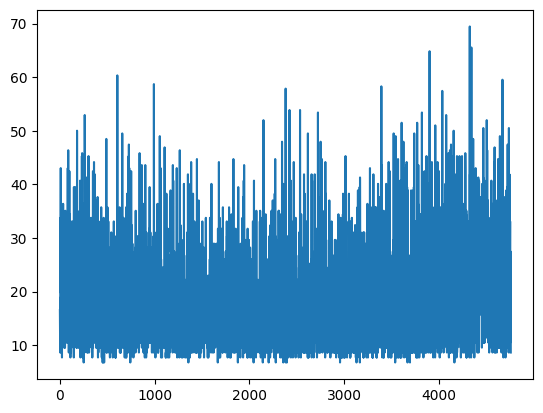

In [40]:
plt.plot(returns)

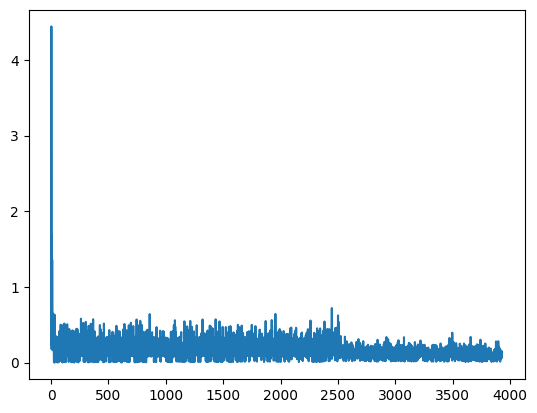

In [18]:
plt.plot(losses)

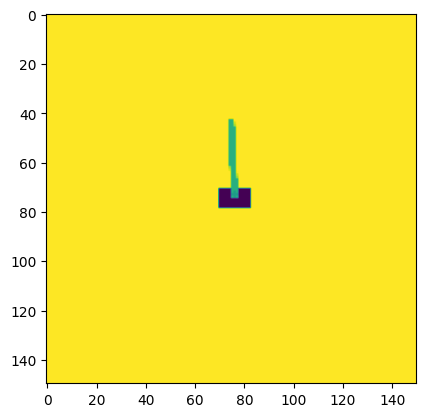

In [17]:
plt.imshow(env.render())

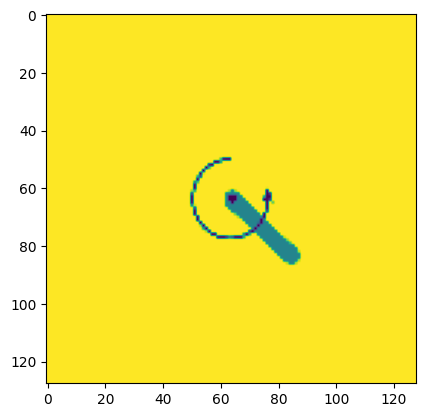

In [118]:
for _ in range(5):
    env.step(24)
plt.imshow(env.render())

In [30]:
g = [evaluate(dqn_model, env) for _ in range(10)]

In [28]:
g_rand = [evaluate(dqn_model, env, eps=1) for _ in range(10)]

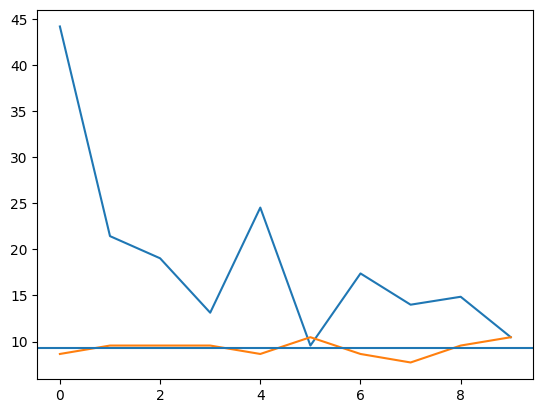

In [31]:
plt.plot(g_rand)
plt.plot(g)
plt.axhline(np.mean(g))

In [32]:
def evaluate(dqn_model, env, eps=0.1, equi=False):
    _, obs = env.reset()
    done = False
    rewards = []
    actions = []
    
    for _ in range(200): # timeout at 1000 steps
        # get greedy action
        if np.random.rand() < eps:
            action = np.random.choice(env.action_space)
        else:
            obs_tensor = torch.tensor(obs.copy(), dtype=torch.float32).unsqueeze(0)
            if equi:
                obs_tensor = obs_tensor.unsqueeze(0)
            q_values = dqn_model(obs_tensor)  # add dim to observation
            max_q_idx = torch.where(q_values == q_values.max())[0]
            action = np.random.choice(max_q_idx.tolist())
    
        _, obs, reward, done = env.step(action)
        rewards.append(reward)

        if done:
            break
    # env.render()
    g = 0
    for r in rewards[::-1]:
        g = 0.99*g + r
    return rewards

/tmp/ipykernel_542158/3000396438.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("dim7_runs250000_4actions.pt")


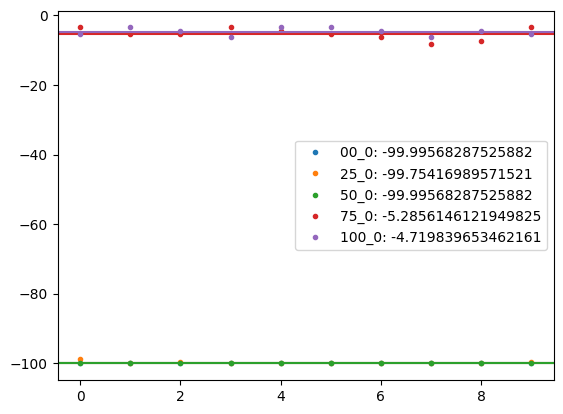

In [103]:
checkpoint = torch.load("dim7_runs25000_4actions.pt")
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
i = 0

for key, value in checkpoint.items():
    dqn = CNNCom()
    dqn.load_state_dict(value["state_dict"])

    g_arr = []
    for _ in range(10):
        g, _ = evaluate(dqn, env, 0.1)
        g_arr.append(g)
    plt.plot(g_arr, '.', color=colors[i], label=f"{key}: {np.mean(g_arr)}")
    plt.axhline(np.mean(g_arr), color=colors[i])
    i += 1

# plt.plot([0, 9], [0.932, .932], 'g', label='optimal rewards')
plt.legend()

In [105]:
x = np.zeros(env.grid.shape)
x[tuple(env.start_state)] = 1

In [118]:
np.argwhere(np.rot90(x, 2))[0]

array([5, 6])

In [106]:
dqn = CNNCom()
dqn.load_state_dict(checkpoint["50_0"]["state_dict"])

<All keys matched successfully>

In [76]:
dqn = CNNCom()

In [17]:
dqn(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0))[0]

tensor(-0.1244, grad_fn=<SelectBackward0>)

In [62]:
rewards = [-1, -1, -1, -1, -1, -1, -1, 1]
g=0
for r in rewards[::-1]:
    g = .99*g + r

In [47]:
maze = MazeEnv(3, 123)
maze_rot = MazeEnv(3, 123, maze.grid, 1)

In [49]:
maze_rot.grid

array([[1. , 1. , 1. , 1. , 1. , 0. , 1. ],
       [1. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [1. , 0. , 1. , 1. , 1. , 0. , 1. ],
       [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
       [1. , 1. , 1. , 0. , 1. , 0. , 1. ],
       [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
       [1. , 0.5, 1. , 1. , 1. , 1. , 1. ]])

In [116]:
env.step(7)
print(env.grid)
x = (dqn_model(torch.tensor(env.grid.copy(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)).reshape(3, 3))
for y in x:
    print(f"{y[0]}\t{y[1]}\t{y[2]}")

[[1.  1.  1.  1.  1.  0.  1. ]
 [1.  0.  0.  0.  0.  0.  1. ]
 [1.  0.  1.  1.  1.  0.  1. ]
 [1.  0.  0.  0.  1.  0.  1. ]
 [1.  1.  1.  0.  1.  0.  1. ]
 [1.  0.  0.  0.  1.  0.5 1. ]
 [1.  0.  1.  1.  1.  1.  1. ]]
0.9423100352287292	2.3529410362243652	1.4532687664031982
1.3097128868103027	1.480532169342041	1.1628659963607788
1.0766695737838745	0.955435574054718	1.4217246770858765


In [22]:
q_values = dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0))  # add dim to observation
max_q_idx = torch.where(q_values == q_values.max())[0]
print((max_q_idx.tolist()))

[7]


In [25]:
x = (dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0)).reshape(3, 3))
for y in x:
    print(f"{y[0]}\t{y[1]}\t{y[2]}")
        

0.8748461008071899	0.8361788988113403	1.5954543352127075
1.667539358139038	1.618808388710022	1.4521780014038086
1.5551992654800415	2.254629373550415	2.3453009128570557


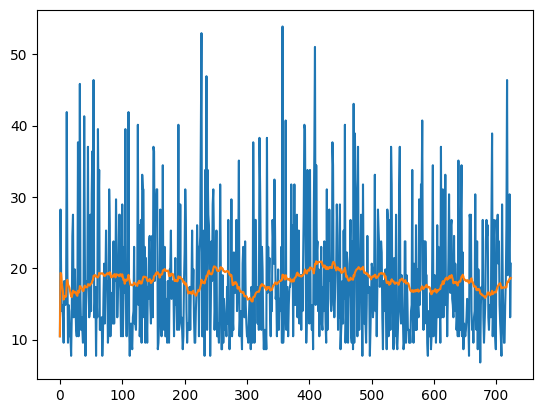

In [38]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

plt.plot(returns)
plt.plot(moving_average(returns))

In [75]:
checkpoint = torch.load("dim7_runs250000_4actions_equi.pt")

/tmp/ipykernel_1963443/2008124539.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("dim7_runs250000_4actions_equi.pt")


In [76]:
dqn = EquivariantCNNCom()
dqn.load_state_dict(checkpoint["100_0"]["state_dict"])
maze = MazeEnv(3, 123)

RuntimeError: Error(s) in loading state_dict for EquivariantCNNCom:
	Missing key(s) in state_dict: "conv.0.expanded_bias", "conv.0.filter", "conv.2.expanded_bias", "conv.2.filter", "conv.4.expanded_bias", "conv.4.filter". 
	Unexpected key(s) in state_dict: "out_layer.0.weight", "out_layer.0.bias", "out_layer.1.weight", "out_layer.1.bias". 
	size mismatch for conv.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for conv.4.weights: copying a param with shape torch.Size([24576]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for conv.4.bias_expansion: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([1, 1]).

In [5]:
g = [evaluate(dqn, maze, 0.01)[0] for _ in range(20)]

In [6]:
maze_rot = MazeEnv(3, 123, maze.grid, 1)
maze_rot.reset()

([6, 1],
 array([[1. , 1. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 0. , 0. , 1. ],
        [1. , 0. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
        [1. , 1. , 1. , 0. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
        [1. , 0.5, 1. , 1. , 1. , 1. , 1. ]]))

In [7]:
g_rot = [evaluate(dqn, maze_rot, 0.01)[0] for _ in range(20)]

In [8]:
g_rot

[-99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882]

In [10]:
# manually evaluate equi dqn
env.reset()

([1, 0],
 array([[1. , 1. , 1. , 1. , 1. , 1. , 1. ],
        [0.5, 0. , 1. , 0. , 0. , 0. , 1. ],
        [1. , 0. , 1. , 0. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
        [1. , 1. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [1. , 1. , 1. , 1. , 1. , 1. , 1. ]]))

In [20]:
env.step(5)

([3, 3],
 array([[1. , 1. , 1. , 1. , 1. , 1. , 1. ],
        [0. , 0. , 1. , 0. , 0. , 0. , 1. ],
        [1. , 0. , 1. , 0. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0.5, 1. , 0. , 1. ],
        [1. , 1. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [1. , 1. , 1. , 1. , 1. , 1. , 1. ]]),
 -1,
 False)

In [21]:
q_values = dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0))  # add dim to observation
max_q_idx = torch.where(q_values == q_values.max())[0]
print((max_q_idx.tolist()))

[1]


In [14]:
q_values

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

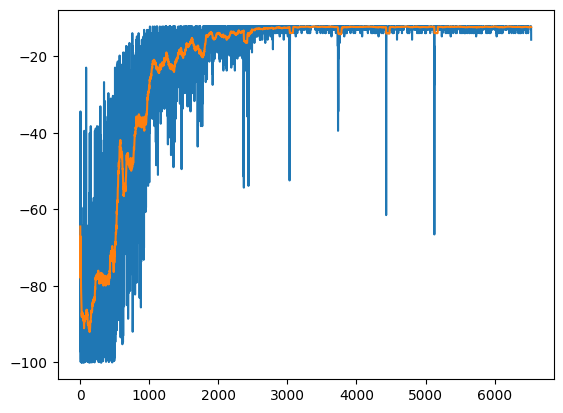

In [62]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

plt.plot(returns)
plt.plot(moving_average(returns))

In [24]:
g_equi = [evaluate(dqn_model, maze, 0.01, True)[0] for _ in range(20)]

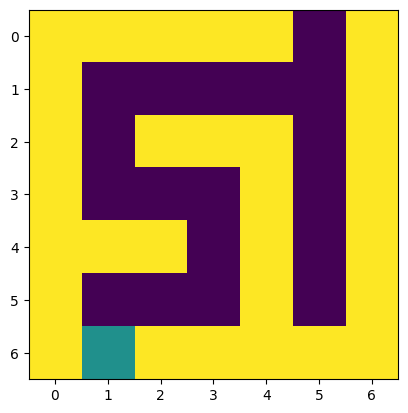

In [39]:
maze_rot.reset()
maze_rot.render()

In [38]:
maze_rot = MazeEnv(3, 123, maze.grid, 1)
maze_rot.reset()
# g_rot_equi = [evaluate(dqn_model, maze_rot, 0.01, True)[0] for _ in range(20)]

([6, 1],
 array([[1. , 1. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 0. , 0. , 1. ],
        [1. , 0. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
        [1. , 1. , 1. , 0. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
        [1. , 0.5, 1. , 1. , 1. , 1. , 1. ]]))

In [33]:
g_rot_equi

[2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 1.5019163870712111,
 2.5271882697689003,
 0.4868972232004989,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003]

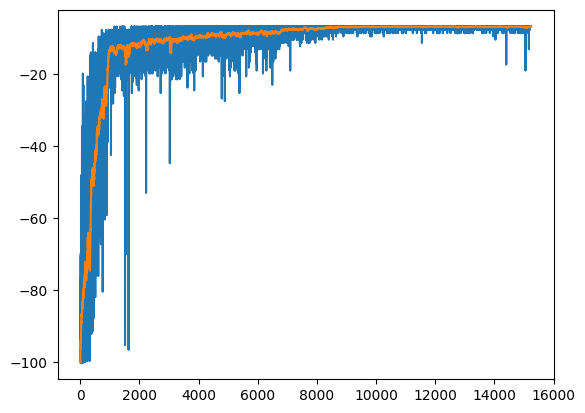

In [9]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

plt.plot(returns)
plt.plot(moving_average(returns))